<a href="https://colab.research.google.com/github/anarvicente/BSI/blob/master/Customer_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão de Churn de Clientes — Customer Churn (Kaggle)

Neste projeto, utilizamos o dataset **Customer Churn**, disponível no Kaggle, para prever se um cliente irá cancelar seu contrato com a empresa (churn).  

## Objetivo
Construir e comparar modelos de Machine Learning capazes de prever o churn de clientes, seguindo o pipeline:

- Exploração e descrição inicial dos dados  
- Tratamento de dados faltantes  
- Codificação de variáveis categóricas  
- Normalização das features  
- Visualizações
- Treinamento com 4 modelos clássicos
- Comparação das métricas (accuracy, precision, recall, F1-score, ROC-AUC)  
- Conclusões e próximos passos  


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, RocCurveDisplay
)

sns.set()
plt.style.use("default")
pd.set_option("display.max_columns", None)


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'telco-customer-churn' dataset.
Path to dataset files: /kaggle/input/telco-customer-churn


In [3]:
import os

# Nome do arquivo dentro do dataset
csv_path = os.path.join(path, "WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Carregar o dataset
df = pd.read_csv(csv_path)

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
print("Formato:", df.shape)
df.info()


Formato: (7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043

In [7]:
'''O dataset pode apresentar valores em branco na coluna TotalCharges. Vamos converter essa coluna para numérico e tratar os erros como NA.'''
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].isna().sum()


np.int64(11)

In [9]:
"Nas linhas faltantes, escolhi preencher com a mediana."
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

In [12]:
"Agora vamos analisar a variável alvo."
df['Churn'].value_counts()
df['Churn'].value_counts(normalize=True) * 100


,proportion
Churn,
No,73.463013
Yes,26.536987


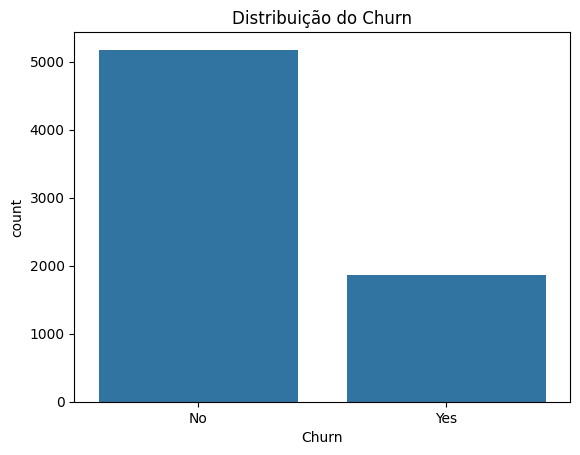

In [15]:
"É desbalanceado, então temos que prestar atenção na métrica de avaliação."

sns.countplot(data=df, x='Churn')
plt.title('Distribuição do Churn')
plt.show()


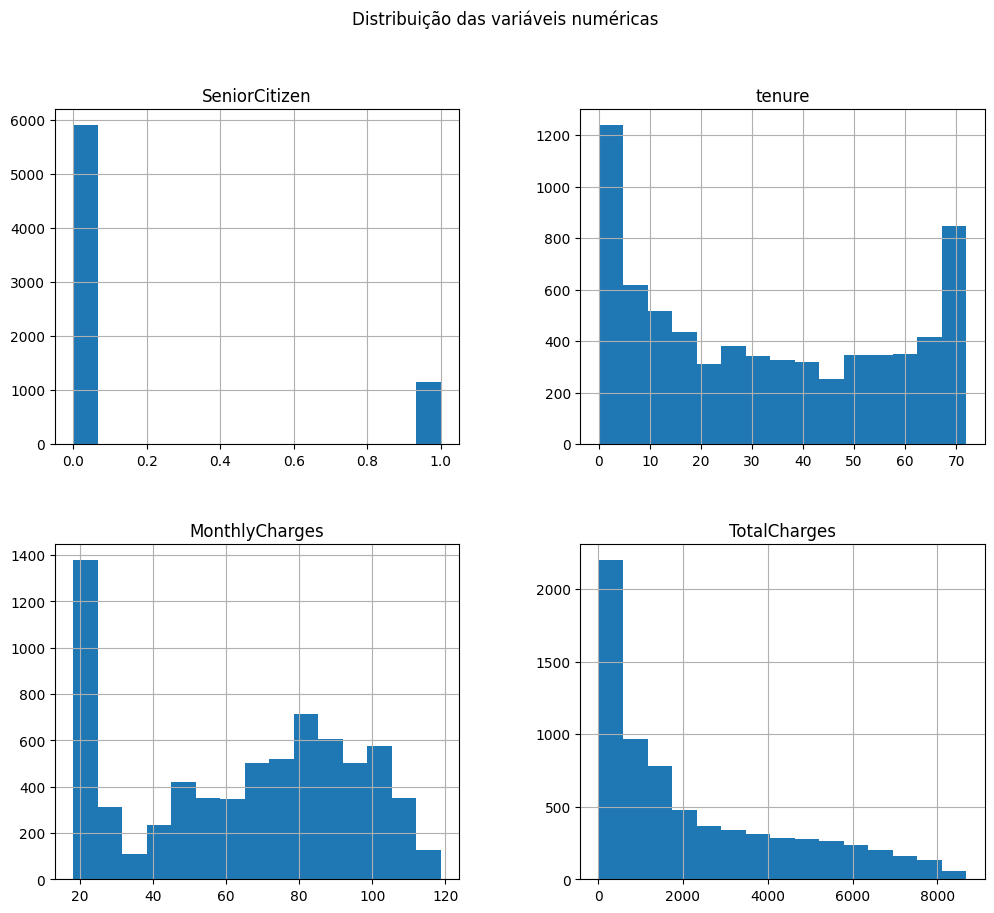

In [16]:
"Vamos verificar a distribuição das colunas numéricas"

numericas = df.select_dtypes(include=['int64','float64']).columns

df[numericas].hist(figsize=(12,10), bins=15)
plt.suptitle("Distribuição das variáveis numéricas")
plt.show()


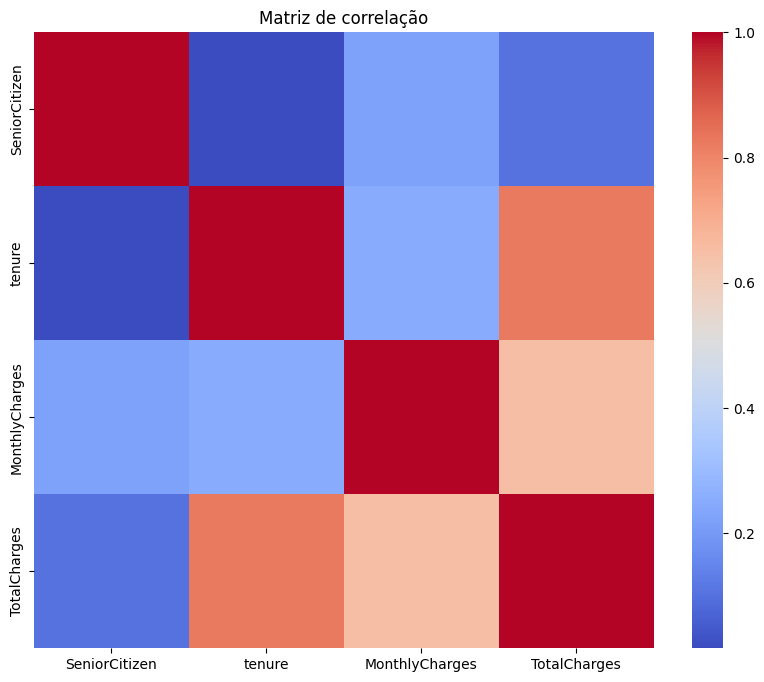

In [17]:
"A correlação entre as variáveis"
plt.figure(figsize=(10,8))
sns.heatmap(df[numericas].corr(), annot=False, cmap='coolwarm')
plt.title("Matriz de correlação")
plt.show()


In [ ]:
'''O heatmap mostrou uma correlação forte entre tenure e TotalCharges, e entre MonthlyCharges e TotalCharges.
Observou-se também correlação negativa entre SeniorCitizen e tenure, indicando que clientes idosos permanecem menos tempo.
As demais correlações são fracas, sugerindo pouca relação linear direta entre valor mensal, idade e tempo de permanência.
Esses padrões ajudam a entender o comportamento do cliente e possíveis fatores associados ao churn.'''

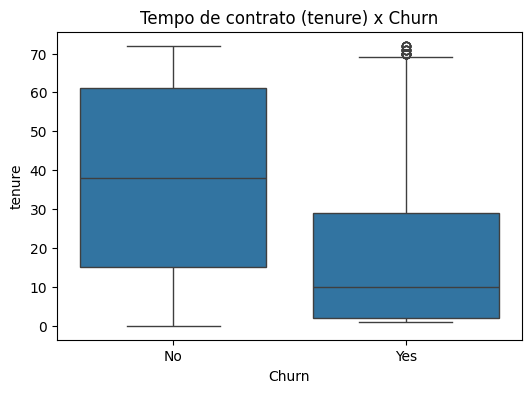

In [18]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='Churn', y='tenure')
plt.title("Tempo de contrato (tenure) x Churn")
plt.show()


In [ ]:
''' Clientes sem churn têm alta permanência (mediana ~40 meses).
    Clientes com churn têm permanência curta (mediana ~9 meses).
    O churn ocorre majoritariamente no início do contrato.'''

In [19]:
''' Separação dos dados'''

X = df.drop(columns=['Churn'])
y = df['Churn'].map({'No':0, 'Yes':1})  # Convertendo para 0 e 1 - como é desbalanceada, a classe minoritária é a positiva


In [20]:
'''Separação clássica de 80/20 '''
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train.shape, X_test.shape


((5634, 19), (1409, 19))

In [21]:
''' Separando as variáveis categóricas e numéricas'''

cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(include=['int64','float64']).columns

cat_cols, num_cols


(Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
        'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
        'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
        'PaperlessBilling', 'PaymentMethod'],
       dtype='object'),
 Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object'))

In [22]:
'''´Pré-processamento básico - OnehotEnconding para as variáveis categóricas e StandardScaler para as numéricas'''

preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), num_cols)
])


In [23]:
''' Função auxiliar de avaliação dos modelos, vamos utilizar 4 modelos'''
def avaliar(modelo, nome):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:,1] if hasattr(modelo, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    print(f"\n=== {nome} ===")
    print(f"Acurácia: {acc:.3f}")
    print(f"Precisão: {prec:.3f}")
    print(f"Recall: {rec:.3f}")
    print(f"F1-score: {f1:.3f}")
    if roc: print(f"ROC-AUC: {roc:.3f}")
    print("\nRelatório de Classificação:\n")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matriz de Confusão — {nome}")
    plt.show()

    return {'modelo':nome,'acc':acc,'prec':prec,'rec':rec,'f1':f1,'roc':roc}



=== Regressão Logística ===
Acurácia: 0.806
Precisão: 0.657
Recall: 0.559
F1-score: 0.604
ROC-AUC: 0.842

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



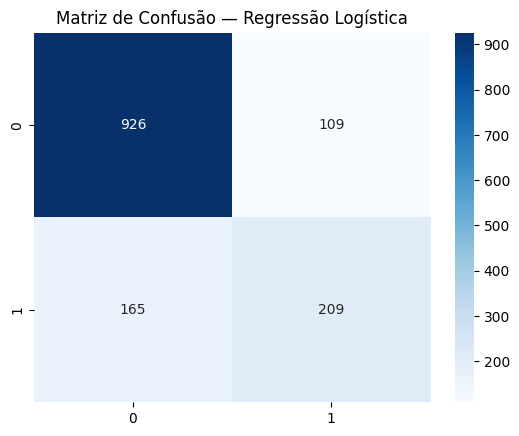

In [24]:
''' Regressão Logística'''
logreg = Pipeline([
    ('prep', preprocess),
    ('model', LogisticRegression(max_iter=1000))
])

result_log = avaliar(logreg, "Regressão Logística")



=== KNN (k=5) ===
Acurácia: 0.764
Precisão: 0.553
Recall: 0.575
F1-score: 0.564
ROC-AUC: 0.790

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1035
           1       0.55      0.57      0.56       374

    accuracy                           0.76      1409
   macro avg       0.70      0.70      0.70      1409
weighted avg       0.77      0.76      0.77      1409



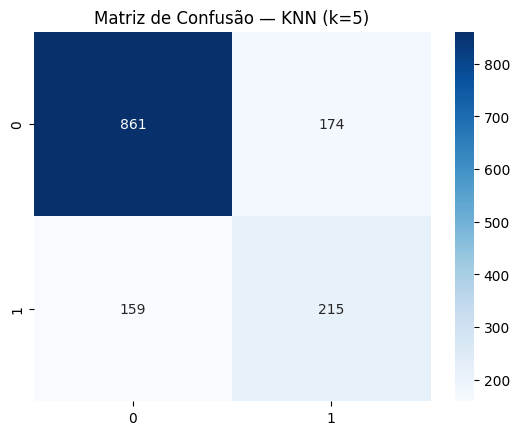

In [25]:
''' KNN '''

knn = Pipeline([
    ('prep', preprocess),
    ('model', KNeighborsClassifier(n_neighbors=5))
])

result_knn = avaliar(knn, "KNN (k=5)")



=== Random Forest ===
Acurácia: 0.784
Precisão: 0.618
Recall: 0.484
F1-score: 0.543
ROC-AUC: 0.819

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.62      0.48      0.54       374

    accuracy                           0.78      1409
   macro avg       0.72      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409



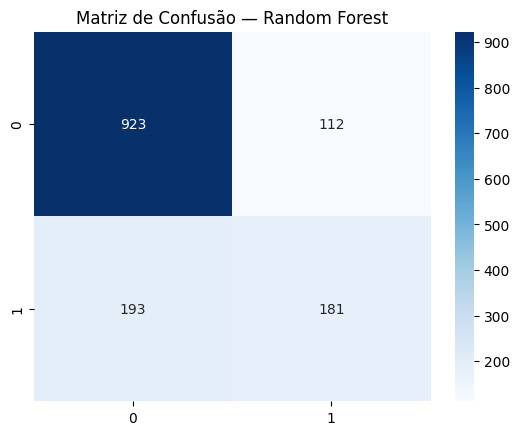

In [27]:
''' Random Forest'''
rf = Pipeline([
    ('prep', preprocess),
    ('model', RandomForestClassifier(
        n_estimators=300,
        random_state=42
    ))
])

result_rf = avaliar(rf, "Random Forest")



=== SVM (RBF) ===
Acurácia: 0.791
Precisão: 0.642
Recall: 0.484
F1-score: 0.552
ROC-AUC: 0.791

Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.64      0.48      0.55       374

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



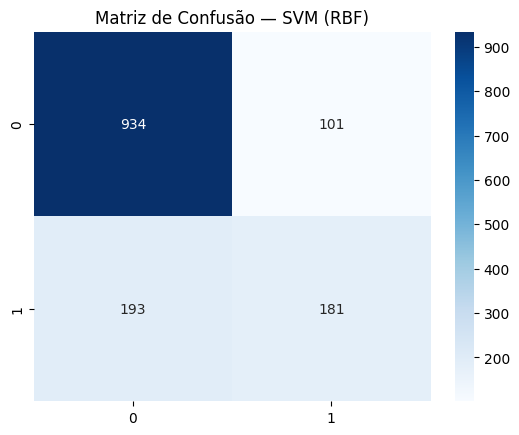

In [28]:
''' SVM '''

svm_clf = Pipeline([
    ('prep', preprocess),
    ('model', SVC(kernel='rbf', probability=True))
])

result_svm = avaliar(svm_clf, "SVM (RBF)")


In [29]:
''' Comparação entre os modelos '''

resultados = pd.DataFrame([
    result_log, result_knn, result_rf, result_svm
])
resultados


,modelo,acc,prec,rec,f1,roc
0,Regressão Logística,0.805536,0.657233,0.558824,0.604046,0.841874
1,KNN (k=5),0.763662,0.552699,0.574866,0.563565,0.789610
2,Random Forest,0.783534,0.617747,0.483957,0.542729,0.819006
3,SVM (RBF),0.791341,0.641844,0.483957,0.551829,0.790511


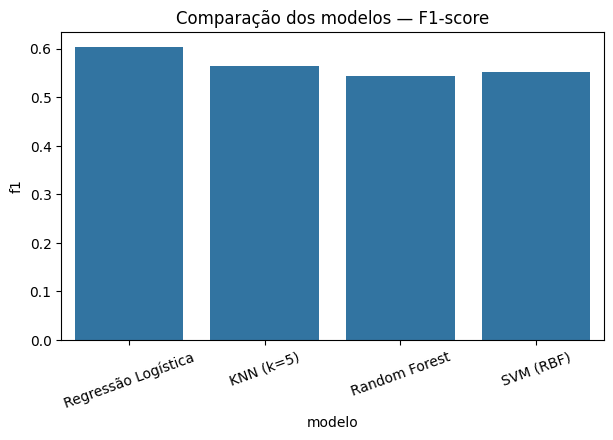

In [30]:
''' Considerando o F1 score como métrica alvo de avaliação, considerando que a base é desbalanceada, ele é o que mais traz o equilíbrio.'''

plt.figure(figsize=(7,4))
sns.barplot(data=resultados, x='modelo', y='f1')
plt.title("Comparação dos modelos — F1-score")
plt.xticks(rotation=20)
plt.show()


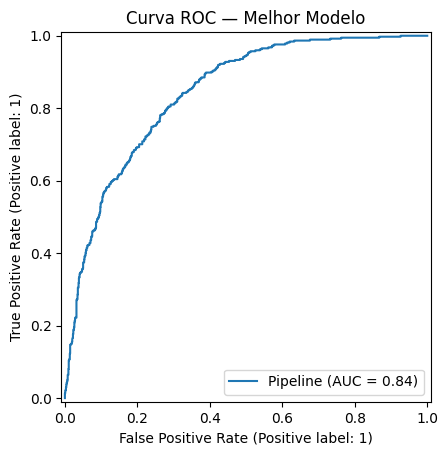

In [31]:
''' Melhor modelo - Regressão Logística '''
best = logreg
best.fit(X_train, y_train)

RocCurveDisplay.from_estimator(best, X_test, y_test)
plt.title("Curva ROC — Melhor Modelo")
plt.show()


In [ ]:
'''A curva ROC mostra que o modelo tem bom desempenho ao separar clientes que cancelam dos que não cancelam.
   O AUC de 0.84 indica que o modelo tem alta capacidade discriminativa'''


## Conclusões

Neste trabalho, analisamos o dataset **Customer Churn** do Kaggle com o objetivo de prever quais clientes têm maior chance de cancelar o serviço.

### Principais achados:

- O dataset apresentou leve desbalanceamento (≈ 27% churn).  
- Realizamos limpeza da coluna `TotalCharges` e transformação de categóricas via One-Hot Encoding.  
- Foram treinados quatro modelos:
  - Regressão Logística  
  - KNN  
  - Random Forest  
  - SVM  

- O modelo **Regressão Logística** apresentou melhor equilíbrio entre precisão, recall e F1-score.
- A curva ROC confirmou boa capacidade discriminativa do modelo.

### Possíveis próximos passos:

- Ajuste fino dos hiperparâmetros com GridSearchCV.
- Testar algoritmos avançados, como XGBoost.
- Aplicar técnicas contra desbalanceamento como SMOTE.
- Avaliar importância das features para interpretar melhor o churn.